# Samples on Bicycle

## Define parameters

In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import jax.numpy as jnp
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]
gamma = parameters["gamma"]

# Sample collection
n_samples = parameters["n_samples"]

# Visualisation of errors and performances
n_omegas = parameters["n_omegas"]
n_thetas = parameters["n_thetas"]

# keys
env_key = jax.random.PRNGKey(env_seed)
env_key, sample_key = jax.random.split(env_key)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [5]:
import numpy as np

from pbo.environments.bicycle import BicycleEnv


env = BicycleEnv(env_key)

## Collect samples

### Samples on the mesh and with a uniform policy

In [6]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
positions = [[env.position]]

for idx_sample in range(n_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    action = jax.random.choice(key, env.actions_on_max)
    
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1
    positions[n_episodes].append(env.position)

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing[0] or n_steps >= 20:
        env.reset()
        positions[n_episodes] = np.array(positions[n_episodes])
        positions.append([])
        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
# assert sum(replay_buffer.rewards == -1) > 0, "No negative reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 500


### Visualize samples

KeyboardInterrupt: 

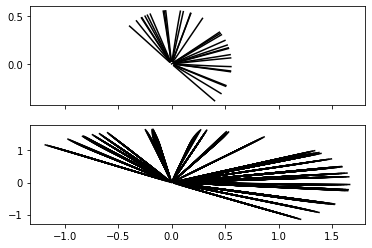

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for episode in range(n_episodes):
    ax1.plot(positions[episode][:, 0], positions[episode][:, 1], color="black")

    for step in range(len(positions[episode])):
        ax2.plot(positions[episode][step, [0, 2]], positions[episode][step, [1, 3]], color="black")


ax1.get_xaxis().set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_ylabel("y")
ax1.set_title(f"Back tire")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title(f"Bicycle", y=0, pad=-30, verticalalignment="top")

plt.subplots_adjust(hspace=0)

In [ ]:
min_omega = replay_buffer.states[:, 0].min(); max_omega = replay_buffer.states[:, 0].max()
omegas = jnp.linspace(min_omega, max_omega, n_omegas)
boxes_omega_size = (max_omega - min_omega) / (n_omegas - 1)
omega_boxes = (np.linspace(min_omega , max_omega + boxes_omega_size, n_omegas + 1) - boxes_omega_size / 2)

min_theta = replay_buffer.states[:, 2].min(); max_theta = replay_buffer.states[:, 2].max()
thetas = jnp.linspace(min_theta , max_theta , n_thetas)
boxes_theta_size = (max_theta - min_theta) / (n_thetas - 1)
theta_boxes = (np.linspace(min_theta , max_theta  + boxes_theta_size, n_thetas + 1) - boxes_theta_size / 2)

In [ ]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


zero_oder_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 2], omega_boxes, theta_boxes, replay_buffer.rewards)
zero_oder_visu_mesh = TwoDimesionsMesh(omegas, thetas, sleeping_time=0, axis_equal=False)

zero_oder_visu_mesh.set_values(zero_oder_count, zeros_to_nan=True)
zero_oder_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\omega$", ylabel=r"$\theta$"
)

In [ ]:
zero_oder_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
zero_oder_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\omega$", ylabel=r"$\theta$"
)

In [ ]:
max_omega_dot = replay_buffer.states[:, 1].max(); min_omega_dot = replay_buffer.states[:, 1].min()
omega_dots = jnp.linspace(min_omega_dot, max_omega_dot, n_omegas)
boxes_omega_dots_size = (max_omega_dot - min_omega_dot) / (n_omegas - 1)
omega_dots_boxes = (np.linspace(min_omega_dot, max_omega_dot + boxes_omega_dots_size, n_omegas + 1) - boxes_omega_dots_size / 2)

In [ ]:
omega_count, n_outside_boxes, rewards_omega_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], omega_boxes, omega_dots_boxes, replay_buffer.rewards)
omega_visu_mesh = TwoDimesionsMesh(omegas, omega_dots, sleeping_time=0, axis_equal=False)

omega_visu_mesh.set_values(omega_count, zeros_to_nan=True)
omega_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\omega$", ylabel=r"$\dot{\omega}$"
)

In [ ]:
omega_visu_mesh.set_values(rewards_omega_count, zeros_to_nan=True)
omega_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\omega$", ylabel=r"$\dot{\omega}$"
)

In [ ]:
max_theta_dot = replay_buffer.states[:, 3].max(); min_theta_dot = replay_buffer.states[:, 3].min()
theta_dots = jnp.linspace(min_theta_dot, max_theta_dot, n_thetas)
boxes_theta_dots_size = (max_theta_dot - min_theta_dot) / (n_thetas - 1)
theta_dots_boxes = (np.linspace(min_theta_dot, max_theta_dot + boxes_theta_dots_size, n_thetas + 1) - boxes_theta_dots_size / 2)

In [ ]:
theta_count, n_outside_boxes, rewards_theta_count = count_samples(replay_buffer.states[:, 2], replay_buffer.states[:, 3], theta_boxes, theta_dots_boxes, replay_buffer.rewards)
theta_visu_mesh = TwoDimesionsMesh(thetas, theta_dots, sleeping_time=0, axis_equal=False)

theta_visu_mesh.set_values(theta_count, zeros_to_nan=True)
theta_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\theta$", ylabel=r"$\dot{\theta}$"
)

In [ ]:
theta_visu_mesh.set_values(rewards_theta_count, zeros_to_nan=True)
theta_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\theta$", ylabel=r"$\dot{\theta}$"
)

## Analysis on the reward

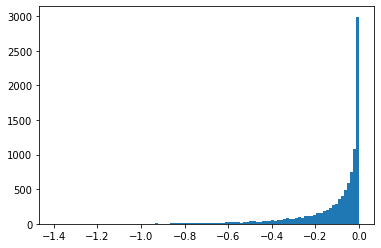

In [8]:
diff_omega = np.array(jnp.abs(replay_buffer.states[:, 0]))

reward_balance = -500 * diff_omega
_ = plt.hist(reward_balance, 100)

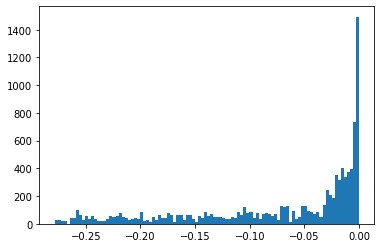

In [9]:
diff_psi = np.array(jnp.square(replay_buffer.states[:, 4]))

reward_direction = -5e-2 * diff_psi
_ = plt.hist(reward_direction, 100)

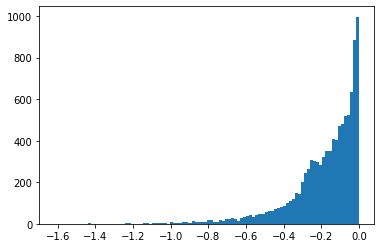

In [10]:
total_reward = reward_balance + reward_direction
_ = plt.hist(total_reward, 100)

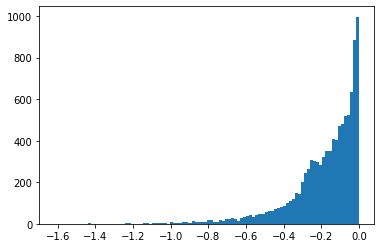

In [12]:
_ = plt.hist(np.array(replay_buffer.rewards.flatten()), 100)